### Import modules

In [1]:
#### Import modules required
import multiprocessing as mp
import numpy as np
import os
import itertools
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import sys
import datetime
from matplotlib import cm

os.chdir("C:/Users/gy17m2a/OneDrive - University of Leeds/Project/RAMP-UA/experiments/calibration")

# PYABC (https://pyabc.readthedocs.io/en/latest/)
import pyabc
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior
# Quieten down the pyopencl info messages (just print errors)
import logging

logging.getLogger("pyopencl").setLevel(logging.ERROR)

# Import arbitrary distribution class for using posterior estimates as new priors
sys.path.append('..')
from ArbitraryDistribution import ArbitraryDistribution

# RAMP model
from microsim.initialisation_cache import InitialisationCache
# from microsim.opencl.ramp.run import run_headless
# from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
# from microsim.opencl.ramp.snapshot import Snapshot
# from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
# from microsim.opencl.ramp.simulator import Simulator
# from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Bespoke RAMP classes for running the model
import sys

sys.path.append('..')
from opencl_runner import OpenCLWrapper  # Some additional functions to simplify running the OpenCL model
from opencl_runner import OpenCLRunner

# Set this to False to recalculate all results (good on HPC or whatever).
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\redis\connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


#### Read spatial data

In [2]:
# from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
# devon_msoa_codes =  pd.read_csv("observation_data/devon_msoa_codes.csv")

#### Create observed cases data
Can maybe move processing into other file and save outputs and just read into avoid confusion

In [3]:
# Observed cases data
cases_msoa_weekly = pd.read_csv("observation_data/weekly_cases_msoas_aggregated_from_daily_IS.csv")
# remove date column
cases_msoa_weekly = cases_msoa_weekly.iloc[:, 1:]
# Transpose
cases_msoa_weekly = cases_msoa_weekly.T

# Observations are cases per msoa.
# Store as an array for us in model (more efficient?)
# (first axis is the msoa number, second is the day)
observations_weekly_array = cases_msoa_weekly.to_numpy()

## Get dataframe with totals for whole of Devon
cases_devon_weekly = pd.read_csv("observation_data/weekly_cases_devon_aggregated_from_daily_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_weekly['CumulativeCases'] = cases_devon_weekly['OriginalCases'].cumsum()

# Read in daily devon case data (interpoalted from weekly)
cases_devon_daily = pd.read_csv("observation_data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_daily['CumulativeCases'] = cases_devon_daily['OriginalCases'].cumsum()

#### Setup Model
Optionally initialise the population, delete the old OpenCL model snapshot (i.e. an already-initialised model) and
re-create a new one. Useful if something may have changed (e.g. changed the lockdown file).


In [4]:
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

DATA_DIR = os.path.join("..", "..", "devon_data")
cache_dir = os.path.join(DATA_DIR, "caches")
cache = InitialisationCache(cache_dir=cache_dir)
if cache.is_empty():
    raise Exception(f"The cache in {cache_dir} has not been initialised. Probably need to run the code a",
                    "few cells up that initialises the population")

individuals_df, activity_locations = cache.read_from_cache()

print(f"Activity locations: {activity_locations}")

Activity locations: {'Home': <Home ActivityLocation>, 'Retail': <Retail ActivityLocation>, 'PrimarySchool': <PrimarySchool ActivityLocation>, 'SecondarySchool': <SecondarySchool ActivityLocation>, 'Work': <Work ActivityLocation>}


#### Define constants
These are not touched by ABC. Include parameters that should not be optimised.

In [5]:
const_params_dict = {
    "current_risk_beta": 0.025239665550846085,  # Global risk multplier (leave this as it is and allow the other parameters to vary)
    "home": 1.0, # Risk associated with being at home. Again leave this constant so the coefficients of other places will vary around it
}


#### Define random variables and the prior distributions
Random variables are the global parameters.

<RV name=uniform, args=(0, 1), kwargs={}>
<RV name=uniform, args=(0, 1), kwargs={}>
<RV name=uniform, args=(0, 1), kwargs={}>
<RV name=beta, args=(0.1, 2), kwargs={}>
<RV name=norm, args=(0.444, 0.155), kwargs={}>
<RV name=norm, args=(0.444, 0.155), kwargs={}>
<RV name=norm, args=(0.444, 0.155), kwargs={}>


C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


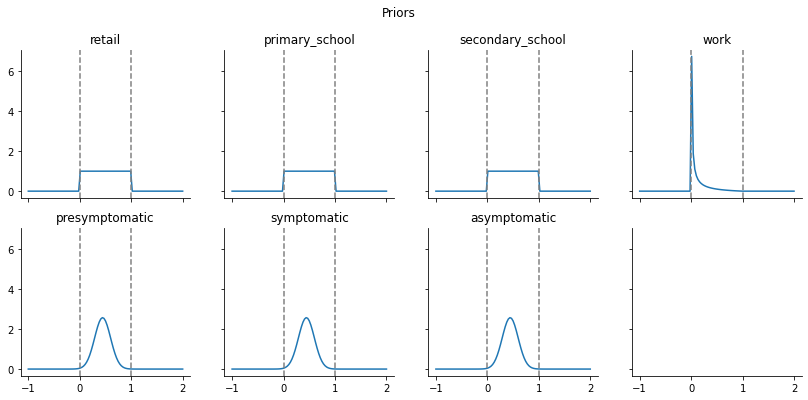

In [6]:
# School and retail multipliers are uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = (pyabc.RV("uniform", 0, 1) for _ in range(3))
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75]  (see justification in abc)
# No idea about (pre)symptomatic, so use same distribution as asymptomatic
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = {
    "retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
    "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv
}

fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True)
x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, (var_name, variable) in enumerate(all_rv.items()):
    print(variable)
    # var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    # ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=0.0, ls='--', color="grey", label="x=0")
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")

# ax.legend()
# fig.tight_layout()
fig.suptitle("Priors")
fig.show()

## Create a distrubtion from these random variables
decorated_rvs = {name: pyabc.LowerBoundDecorator(rv, 0.0) for name, rv in all_rv.items()}

# Define the original priors
original_priors = pyabc.Distribution(**decorated_rvs)

#### Setup loop for running model

In [7]:
# Path to parameters
parameters_file = os.path.join("../../", "model_parameters/",
                               "default.yml")  # Need to tell it where the default parameters are
# Set the size of a data assimilation window in days:
da_window_size = 14
# Dictionary with parameters for running model
admin_params = {"quiet": True, "use_gpu": True, "store_detailed_counts": True, "start_day": 0,
                "run_length": da_window_size,
                "current_particle_pop_df": None,
                "parameters_file": parameters_file, "snapshot_file": SNAPSHOT_FILEPATH, "opencl_dir": OPENCL_DIR,
                "individuals_df": individuals_df, "observations_weekly_array": observations_weekly_array,
                 'num_seed_days' :7}

# Create dictionaries to store the dfs, weights or history from each window (don't need all of these, but testing for now)
dfs_dict = {}
weights_dict = {}
history_dict = {}

# Store starting time to use to calculate how long processing the whole window has taken
starting_windows_time = datetime.datetime.now()

# Define number of windows to run for
windows = 2

# Loop through each window
for window_number in range(1, windows + 1):
    print("Window number: ", window_number)

    # Edit the da_window size in the admin params
    # print("Running for 14 days")
    admin_params['run_length'] = admin_params['run_length'] * window_number
    print("Running for {} days".format(da_window_size * window_number))

    # Create template for model
    template = OpenCLWrapper(const_params_dict, **admin_params)
    # Not sure why this is needed. Wthout it we get an error when passing the template object to ABCSMC below
    template.__name__ = OpenCLWrapper.__name__

    # Define priors
    # If first window, then use user-specified (original) priors
    if window_number == 1:
        priors = original_priors
    # If a subsequent window, then generate distribution from posterior from previous window
    else:
        priors = ArbitraryDistribution(abc_history)

    # Set up model
    abc = pyabc.ABCSMC(
        models=template,  # Model (could be a list)
        parameter_priors=priors,  # Priors (could be a list)
        # summary_statistics=OpenCLWrapper.summary_stats,  # Summary statistics function (output passed to 'distance')
        distance_function=OpenCLWrapper.dummy_distance,  # Distance function
        sampler=pyabc.sampler.SingleCoreSampler()
        # Single core because the model is parallelised anyway (and easier to debug)
        # sampler=pyabc.sampler.MulticoreEvalParallelSampler()  # The default sampler
        # transition=transition,  # Define how to transition from one population to the next
    )

    # Prepare to run the model
    db_path = ("sqlite:///" + "ramp_da.db")  # Path to database

    # abc.new() needs the database location and any observations that we will use (these are passed to the
    # distance_function provided to pyabc.ABCSMC above). Currently the observations are provided to the model
    # when it is initialised and these are then used at the end of the model run() function. So they don't
    # need to be provided here.
    run_id = abc.new(
        db=db_path,
        observed_sum_stat=None  # {'observation': observations_array, "individuals": individuals_df}
    )

    # Run model
    abc_history = abc.run(max_nr_populations=2)

    # Save some info on the posterior parameter distributions.
    for t in range(0, abc.history.max_t + 1):
        print(t)
        # for this t (population) extract the 100 particle parameter values, and their weights
        df_t1, w_t1 = abc.history.get_distribution(m=0, t=t)
        # Are these equivalent? yes!
        # df_t1_2, w_t1_2 = abc_history.get_distribution(m=0, t=abc_history.max_t)
        # df_t1.equals(df_t1_2)
        # (w_t1 == w_t1_2).all()

        # Save these for use in plotting the prior on the plot of parameter values in each population
        dfs_dict["w{},pop{}".format(window_number, t)] = df_t1
        weights_dict["w{}, pop{}".format(window_number, t)] = w_t1
        history_dict["w{}".format(window_number)] = abc_history

Window number:  1
Running for 14 days


c:\users\gy17m2a\onedrive - university of leeds\project\ramp-ua\microsim\opencl\ramp\params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file. This warning will not be displayed again.
  warnings.warn("Params object is being created using hard-coded default values, "
ABC.History INFO: Start <ABCSMC id=25, start_time=2022-02-17 18:10:40>
ABC INFO: Calibration sample t = -1.


OpenclRunner ran model 1 in 0:00:06.597287
OpenclRunner ran model 2 in 0:00:02.795946
OpenclRunner ran model 3 in 0:00:03.273068
OpenclRunner ran model 4 in 0:00:03.738980
OpenclRunner ran model 5 in 0:00:03.210637
OpenclRunner ran model 6 in 0:00:03.242312
OpenclRunner ran model 7 in 0:00:02.870490
OpenclRunner ran model 8 in 0:00:02.763840
OpenclRunner ran model 9 in 0:00:03.287548
OpenclRunner ran model 10 in 0:00:02.700235
OpenclRunner ran model 11 in 0:00:03.553122
OpenclRunner ran model 12 in 0:00:03.458112
OpenclRunner ran model 13 in 0:00:02.971356
OpenclRunner ran model 14 in 0:00:03.860364
OpenclRunner ran model 15 in 0:00:03.449050
OpenclRunner ran model 16 in 0:00:03.230679
OpenclRunner ran model 17 in 0:00:03.206107
OpenclRunner ran model 18 in 0:00:02.755282
OpenclRunner ran model 19 in 0:00:03.257233
OpenclRunner ran model 20 in 0:00:02.636256
OpenclRunner ran model 21 in 0:00:03.047429
OpenclRunner ran model 22 in 0:00:03.180390
OpenclRunner ran model 23 in 0:00:02.7840

ABC INFO: t: 0, eps: 8.20309832e+03.


OpenclRunner ran model 101 in 0:00:03.574208
OpenclRunner ran model 102 in 0:00:03.493825
OpenclRunner ran model 103 in 0:00:03.044945
OpenclRunner ran model 104 in 0:00:03.364840
OpenclRunner ran model 105 in 0:00:02.950235
OpenclRunner ran model 106 in 0:00:03.192158
OpenclRunner ran model 107 in 0:00:02.677544
OpenclRunner ran model 108 in 0:00:02.751820
OpenclRunner ran model 109 in 0:00:03.201180
OpenclRunner ran model 110 in 0:00:02.636277
OpenclRunner ran model 111 in 0:00:03.170409
OpenclRunner ran model 112 in 0:00:02.851532
OpenclRunner ran model 113 in 0:00:02.997818
OpenclRunner ran model 114 in 0:00:03.486440
OpenclRunner ran model 115 in 0:00:02.951105
OpenclRunner ran model 116 in 0:00:03.192780
OpenclRunner ran model 117 in 0:00:03.171888
OpenclRunner ran model 118 in 0:00:02.816782
OpenclRunner ran model 119 in 0:00:03.090384
OpenclRunner ran model 120 in 0:00:02.650161
OpenclRunner ran model 121 in 0:00:03.203164
OpenclRunner ran model 122 in 0:00:02.741920
OpenclRunn

OpenclRunner ran model 284 in 0:00:03.565244
OpenclRunner ran model 285 in 0:00:03.558826
OpenclRunner ran model 286 in 0:00:03.380238
OpenclRunner ran model 287 in 0:00:03.184323
OpenclRunner ran model 288 in 0:00:02.551420
OpenclRunner ran model 289 in 0:00:02.925868
OpenclRunner ran model 290 in 0:00:02.664544
OpenclRunner ran model 291 in 0:00:02.689030
OpenclRunner ran model 292 in 0:00:02.656896
OpenclRunner ran model 293 in 0:00:03.188282
OpenclRunner ran model 294 in 0:00:02.922423
OpenclRunner ran model 295 in 0:00:03.079162
OpenclRunner ran model 296 in 0:00:03.457118
OpenclRunner ran model 297 in 0:00:03.045933
OpenclRunner ran model 298 in 0:00:02.883743
OpenclRunner ran model 299 in 0:00:02.884273
OpenclRunner ran model 300 in 0:00:02.944749
OpenclRunner ran model 301 in 0:00:03.138603
OpenclRunner ran model 302 in 0:00:02.604161
OpenclRunner ran model 303 in 0:00:02.903768
OpenclRunner ran model 304 in 0:00:02.628304
OpenclRunner ran model 305 in 0:00:02.847563
OpenclRunn

ABC INFO: Accepted: 100 / 220 = 4.5455e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 7.33959832e+03.


OpenclRunner ran model 321 in 0:00:03.163957
OpenclRunner ran model 322 in 0:00:02.962607
OpenclRunner ran model 323 in 0:00:03.301406
OpenclRunner ran model 324 in 0:00:02.572250
OpenclRunner ran model 325 in 0:00:03.153098
OpenclRunner ran model 326 in 0:00:02.594759
OpenclRunner ran model 327 in 0:00:02.933374
OpenclRunner ran model 328 in 0:00:03.062836
OpenclRunner ran model 329 in 0:00:03.614088
OpenclRunner ran model 330 in 0:00:03.459103
OpenclRunner ran model 331 in 0:00:03.147616
OpenclRunner ran model 332 in 0:00:03.025600
OpenclRunner ran model 333 in 0:00:02.729981
OpenclRunner ran model 334 in 0:00:03.235601
OpenclRunner ran model 335 in 0:00:03.069854
OpenclRunner ran model 336 in 0:00:02.532059
OpenclRunner ran model 337 in 0:00:02.794493
OpenclRunner ran model 338 in 0:00:02.665996
OpenclRunner ran model 339 in 0:00:03.139582
OpenclRunner ran model 340 in 0:00:03.304880
OpenclRunner ran model 341 in 0:00:03.223013
OpenclRunner ran model 342 in 0:00:03.479402
OpenclRunn

OpenclRunner ran model 504 in 0:00:01.972124
OpenclRunner ran model 505 in 0:00:02.512738
OpenclRunner ran model 506 in 0:00:02.039356
OpenclRunner ran model 507 in 0:00:02.435722
OpenclRunner ran model 508 in 0:00:02.075761
OpenclRunner ran model 509 in 0:00:02.050977
OpenclRunner ran model 510 in 0:00:01.983037
OpenclRunner ran model 511 in 0:00:02.033103
OpenclRunner ran model 512 in 0:00:02.043680
OpenclRunner ran model 513 in 0:00:02.038333
OpenclRunner ran model 514 in 0:00:01.982050
OpenclRunner ran model 515 in 0:00:01.967631
OpenclRunner ran model 516 in 0:00:02.282061
OpenclRunner ran model 517 in 0:00:02.446304


ABC INFO: Accepted: 100 / 197 = 5.0761e-01, ESS: 3.4536e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=25, duration=0:45:18.757063, end_time=2022-02-17 18:55:59>


0
1
Window number:  2
Running for 28 days


ABC.History INFO: Start <ABCSMC id=26, start_time=2022-02-17 18:55:59>
ABC INFO: Calibration sample t = -1.


OpenclRunner ran model 518 in 0:00:02.952188
OpenclRunner ran model 519 in 0:00:03.174929
OpenclRunner ran model 520 in 0:00:03.110414
OpenclRunner ran model 521 in 0:00:03.092145
OpenclRunner ran model 522 in 0:00:03.235231
OpenclRunner ran model 523 in 0:00:03.628716
OpenclRunner ran model 524 in 0:00:03.202202
OpenclRunner ran model 525 in 0:00:03.195095
OpenclRunner ran model 526 in 0:00:03.161087
OpenclRunner ran model 527 in 0:00:03.175436
OpenclRunner ran model 528 in 0:00:03.869561
OpenclRunner ran model 529 in 0:00:03.524111
OpenclRunner ran model 530 in 0:00:03.192148
OpenclRunner ran model 531 in 0:00:03.755872
OpenclRunner ran model 532 in 0:00:03.713779
OpenclRunner ran model 533 in 0:00:03.455666
OpenclRunner ran model 534 in 0:00:03.681307
OpenclRunner ran model 535 in 0:00:03.695741
OpenclRunner ran model 536 in 0:00:03.021362
OpenclRunner ran model 537 in 0:00:03.470384
OpenclRunner ran model 538 in 0:00:03.179500
OpenclRunner ran model 539 in 0:00:03.717084
OpenclRunn

ABC INFO: t: 0, eps: 4.09419632e+04.


OpenclRunner ran model 618 in 0:00:03.174436
OpenclRunner ran model 619 in 0:00:03.679859
OpenclRunner ran model 620 in 0:00:03.162421
OpenclRunner ran model 621 in 0:00:03.206635
OpenclRunner ran model 622 in 0:00:03.714163
OpenclRunner ran model 623 in 0:00:03.687263
OpenclRunner ran model 624 in 0:00:03.632570
OpenclRunner ran model 625 in 0:00:03.022125
OpenclRunner ran model 626 in 0:00:03.151913
OpenclRunner ran model 627 in 0:00:03.150621
OpenclRunner ran model 628 in 0:00:03.702638
OpenclRunner ran model 629 in 0:00:03.130749
OpenclRunner ran model 630 in 0:00:03.706437
OpenclRunner ran model 631 in 0:00:03.406229
OpenclRunner ran model 632 in 0:00:03.163424
OpenclRunner ran model 633 in 0:00:03.129297
OpenclRunner ran model 634 in 0:00:03.533062
OpenclRunner ran model 635 in 0:00:03.666459
OpenclRunner ran model 636 in 0:00:03.608893
OpenclRunner ran model 637 in 0:00:03.128730
OpenclRunner ran model 638 in 0:00:03.151558
OpenclRunner ran model 639 in 0:00:03.698323
OpenclRunn

OpenclRunner ran model 801 in 0:00:03.441368
OpenclRunner ran model 802 in 0:00:03.327827
OpenclRunner ran model 803 in 0:00:03.251870
OpenclRunner ran model 804 in 0:00:03.306333
OpenclRunner ran model 805 in 0:00:03.435786
OpenclRunner ran model 806 in 0:00:03.363850
OpenclRunner ran model 807 in 0:00:03.443726
OpenclRunner ran model 808 in 0:00:03.212388
OpenclRunner ran model 809 in 0:00:03.192224
OpenclRunner ran model 810 in 0:00:03.175040
OpenclRunner ran model 811 in 0:00:03.183377
OpenclRunner ran model 812 in 0:00:02.989849
OpenclRunner ran model 813 in 0:00:03.185010
OpenclRunner ran model 814 in 0:00:03.389661
OpenclRunner ran model 815 in 0:00:03.254219
OpenclRunner ran model 816 in 0:00:03.597981
OpenclRunner ran model 817 in 0:00:03.378388
OpenclRunner ran model 818 in 0:00:03.246538
OpenclRunner ran model 819 in 0:00:03.195755
OpenclRunner ran model 820 in 0:00:03.180378
OpenclRunner ran model 821 in 0:00:03.261695
OpenclRunner ran model 822 in 0:00:03.306841
OpenclRunn

ABC INFO: Accepted: 100 / 223 = 4.4843e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 1.90059632e+04.


OpenclRunner ran model 841 in 0:00:03.083010
OpenclRunner ran model 842 in 0:00:03.125788
OpenclRunner ran model 843 in 0:00:03.201051
OpenclRunner ran model 844 in 0:00:03.195678
OpenclRunner ran model 845 in 0:00:03.237920
OpenclRunner ran model 846 in 0:00:03.111439
OpenclRunner ran model 847 in 0:00:03.120371
OpenclRunner ran model 848 in 0:00:03.192254
OpenclRunner ran model 849 in 0:00:03.150350
OpenclRunner ran model 850 in 0:00:03.346123
OpenclRunner ran model 851 in 0:00:03.161083
OpenclRunner ran model 852 in 0:00:03.348277
OpenclRunner ran model 853 in 0:00:03.180777
OpenclRunner ran model 854 in 0:00:03.343498
OpenclRunner ran model 855 in 0:00:03.157007
OpenclRunner ran model 856 in 0:00:03.217389
OpenclRunner ran model 857 in 0:00:03.160013
OpenclRunner ran model 858 in 0:00:03.295950
OpenclRunner ran model 859 in 0:00:03.428660
OpenclRunner ran model 860 in 0:00:03.190270
OpenclRunner ran model 861 in 0:00:03.371851
OpenclRunner ran model 862 in 0:00:03.453020
OpenclRunn

ABC INFO: Accepted: 100 / 166 = 6.0241e-01, ESS: 2.5900e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=26, duration=1:09:36.529818, end_time=2022-02-17 20:05:36>


0
1


#### Get results at end of each window

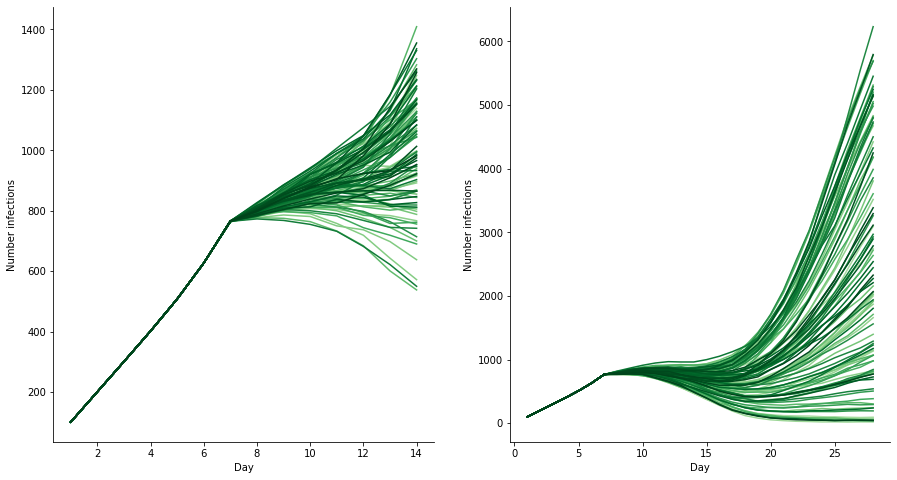

In [8]:
df = pd.DataFrame()
fig, axes = plt.subplots(1, 2, figsize=(15,8))
colors ={'w1': 'darkred', 'w2': 'darkblue'}
axes_number = 0
for window, n_days in { "w1": 14, "w2":28}.items():
    x=range(1,n_days+1)    
    history  = history_dict[window]   
    weighted_sum_stats_t0 = history.get_weighted_sum_stats_for_model(t=0)[1]
    
    evenly_spaced_interval = np.linspace(0.35, 1, 100)
    colors = [cm.Greens(x) for x in evenly_spaced_interval]
    for particle_no in range(0,100):
        particle_x_dict = weighted_sum_stats_t0[particle_no]
        cumulative_model_diseased_by_area = particle_x_dict["cumulative_model_diseased_by_area"]
        cumulative_model_diseased_by_area = cumulative_model_diseased_by_area.iloc[:,0:n_days]
        cumulative_model_diseased_by_area_devon_sum = cumulative_model_diseased_by_area.sum(axis=0)
    
        # Create dataframe to populate with results
        cumulative_model_diseased_by_area_weekly_sum = pd.DataFrame()
        # Define n weeks
        n_weeks = int(n_days / 7)
        # Loop through each week in n_weeks, find total number of cases in that week
        # for each MSOA, add column to dataframe containing this total
        for i in range(7, (n_weeks * 7) + 7, 7):
            weekly_total = cumulative_model_diseased_by_area.iloc[:, 0:i].sum(axis=1)
            #cumulative_model_diseased_by_area_weekly_sum["week{}Sum".format(int(i / 7))] = weekly_total
        # Sum over MSOAs
        cumulative_model_diseased_by_area_weekly_sum = cumulative_model_diseased_by_area_weekly_sum.sum(axis=0)
        df[particle_no] = cumulative_model_diseased_by_area_devon_sum
        
        axes[axes_number].plot(x,cumulative_model_diseased_by_area_devon_sum, color = colors[particle_no])
 
    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_ylabel("Number infections")
    
    axes_number =axes_number +1

#### Plot the parameter values being used in each window
Doesn't work, unless rerun prior bit at top, not sure why

ValueError: x and y must have same first dimension, but have shapes (99,) and (28,)

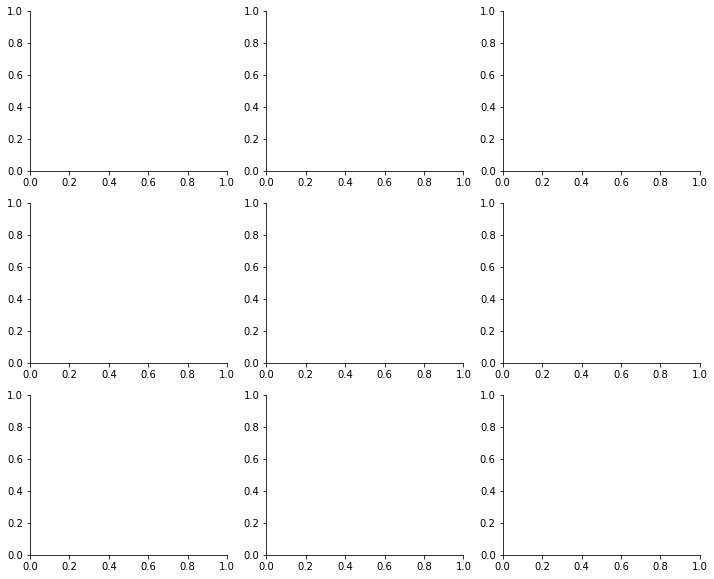

In [9]:
#### Final population for each window
evenly_spaced_interval = np.linspace(0.35, 1, 3)
colors = [cm.Greens(x) for x in evenly_spaced_interval]

fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
for i, param in enumerate(original_priors.keys()):
    color_i =0
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    for history_name, history in history_dict.items():
        color = colors[color_i]
        df, w = history.get_distribution(m=0, t=history.max_t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label=history_name, linewidth = 4,
                color= color)
        ax.legend(fontsize="small")
        ax.set_title(f"{param}")
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
        color_i = color_i +1
fig.legend(handles, labels, loc='center right', fontsize = 17,
            bbox_to_anchor=(1.01, 0.17))
          # ncol = 8, bbox_to_anchor=(0.5, -0.07))
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()
# fig.savefig("Plots/8windows_14days_each_finalpop.jpg")

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


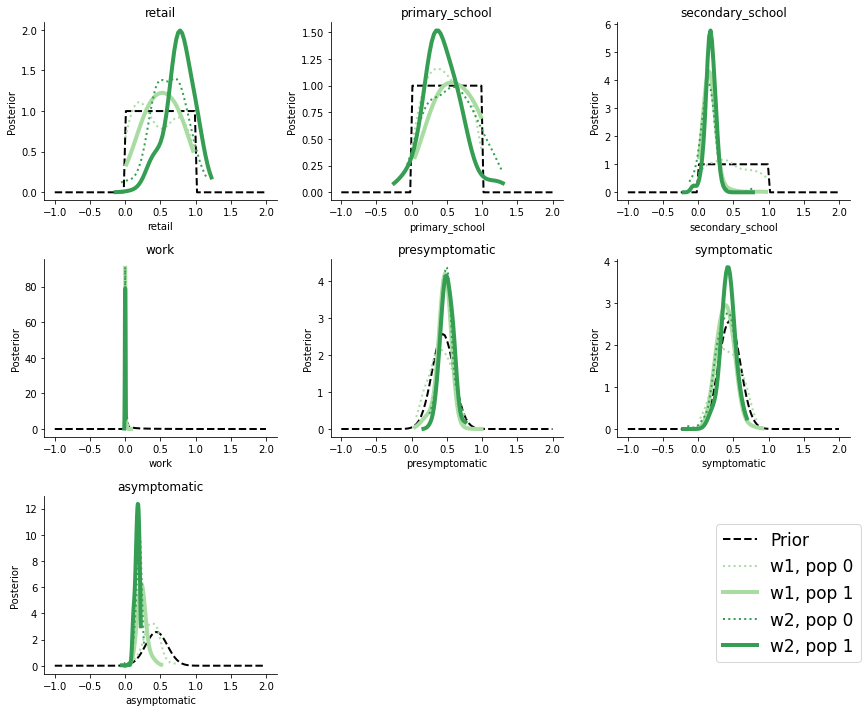

In [39]:
### Plot all populations for each window
evenly_spaced_interval = np.linspace(0.35, 1, 3)
colors = [cm.Greens(x) for x in evenly_spaced_interval]
linestyles = ['dotted','solid'] # check this is same length as n populations
linewidths = [2,4]
fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
for i, param in enumerate(original_priors.keys()):
    color_i =0
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    for history_name, history in history_dict.items():
        color = colors[color_i]
        for t in range(history.max_t + 1):
            df, w = history.get_distribution(m=0, t=t)
            pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label="{}, pop {}".format(history_name, t),
                color = color,
                linestyle = linestyles[t],linewidth = linewidths[t])
            ax.legend(fontsize="small")
            #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
            ax.set_title(f"{param}")
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()
        color_i = color_i +1
        
fig.legend(handles, labels, loc='center right', fontsize = 17,
            bbox_to_anchor=(1.01, 0.17))
          # ncol = 8, bbox_to_anchor=(0.5, -0.07))
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()

#### Run the model X (50?) times using paramater values drawn from the posterior
Plot the results to compare the performance of the model with the observations

In [10]:
# Initialise the class so that its ready to run the model.
## Define parameters
PARAMETERS_FILE = os.path.join("../../", "model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

ITERATIONS = 105  # Number of iterations to run for
assert (ITERATIONS /7).is_integer()
NUM_SEED_DAYS = 7  # Number of days to seed the population
USE_GPU = True
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True
# assert ITERATIONS < len(OBSERVATIONS), \
# f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

OpenCLRunner.init(iterations=ITERATIONS,
                  repetitions=REPETITIONS,
                  observations=cases_devon_weekly,
                  use_gpu=USE_GPU,
                  use_healthier_pop=USE_HEALTHIER_POP,
                  store_detailed_counts=STORE_DETAILED_COUNTS,
                  parameters_file=PARAMETERS_FILE,
                  opencl_dir=OPENCL_DIR,
                  snapshot_filepath=SNAPSHOT_FILEPATH,
                  num_seed_days = NUM_SEED_DAYS)

# Set constants 
OpenCLRunner.set_constants(const_params_dict)

##### define the abc_history object (not necessary as this will be most recent abc_history anyway)
abc_history = history_dict['w2']

# Define the number of samples to take from the posterior distribution of parameters
N_samples = 30
df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)

# Sample from the dataframe of posteriors using KDE
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)
samples = kde.rvs(N_samples)

# Now run N models and store the results of each one
fitness_l = []  # Fitness values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters objects used in each sample (all parameters in the model)
out_calibrated_params_l = []  # The values of the specific calibrated parameters for the sample
summaries_l = []  # The summaries objects

negative_count = 0  # Count the number of negatives returned in the KDE posterior
for i, sample in samples.iterrows():
    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        # while (any(value < 0 for value in sample.values())):
        print("Found negatives. Resampling")
        negative_count += 1
        sample = kde.rvs()
        # Added in this line as the sample was in the wrong format for the while loop
        sample = pd.Series(sample)

    # Create a dictionary with the parameters and their values for this sample
    #param_values = {param: sample[str(param)] for param in priors}
    param_values = sample.to_dict()
    print(param_values)
    # Run the model
    # _fitness = fitness (comparison between sim and obs)
    # _sim =  model_weekly_cumulative_infections
    # _obs = obs_weekly_cumulative_infections
    # _out_params = 
    # _summaries = 
    (_fitness, _sim, _obs, _out_params, _summaries) = \
        OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
    print(f"Fitness: {_fitness}.")
    # print(f"Fitness: {_fitness}. Sample: {sample}")

    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

print(f"Finished sampling. Ignored {negative_count} negative samples.")

# Sanity check - that observations in each case are the same length?
for i in range(len(obs_l) - 1):
    assert np.array_equal(obs_l[0], obs_l[i])

# Save these because it took ages to sample
def pickle_samples(mode, *arrays):
    if mode == "save":
        with open("abc-2-samples.pkl", "wb") as f:
            for x in arrays:
                pickle.dump(x, f)
        return
    elif mode == "load":
        with open("abc-2-samples.pkl", "rb") as f:
            fitness_l = pickle.load(f)
            sim_l = pickle.load(f)
            obs_l = pickle.load(f)
            out_params_l = pickle.load(f)
            out_calibrated_params_l = pickle.load(f)
            summaries_l = pickle.load(f)
        return (fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)
    else:
        raise Exception(f"Unkonwn mode: {mode}")

pickle_samples('save', fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)

# print(f"Original fitness: {round(fitness0)}\nOptimised fitness: {round(fitness)}")

{'asymptomatic': 0.06543587282168596, 'presymptomatic': 0.5288703230467471, 'primary_school': 1.0041911372541552, 'retail': 0.6547149918689991, 'secondary_school': 0.24057399985429034, 'symptomatic': 0.41123331511250966, 'work': 0.018372281586190885}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.18s/it]


Fitness: 40579.51755013779.
{'asymptomatic': 0.02519066110263029, 'presymptomatic': 0.5938302290082041, 'primary_school': 0.35132466473322777, 'retail': 0.6178058667865174, 'secondary_school': 0.7038688082618533, 'symptomatic': 0.5177861967643876, 'work': 0.010940080325691638}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.79s/it]


Fitness: 42280.33341888601.
Found negatives. Resampling
{'asymptomatic': 0.08151407177108824, 'presymptomatic': 0.5983017258835162, 'primary_school': 0.29561238326701766, 'retail': 0.5254886473594387, 'secondary_school': 0.07375261461189336, 'symptomatic': 0.46057383115486, 'work': 0.015572682227509375}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.73s/it]


Fitness: 38994.35032620923.
Found negatives. Resampling
{'asymptomatic': 0.10538954837713108, 'presymptomatic': 0.2679434593260553, 'primary_school': 0.3495850521380665, 'retail': 0.3317437890053633, 'secondary_school': 0.6132942361973049, 'symptomatic': 0.6360451327870735, 'work': 0.015179251941852871}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.78s/it]


Fitness: 37249.994210660334.
{'asymptomatic': 0.08696870744127948, 'presymptomatic': 0.6167735165336308, 'primary_school': 0.7611126570050216, 'retail': 0.4287718438932222, 'secondary_school': 0.5097738926327002, 'symptomatic': 0.03407522278096468, 'work': 0.016902521883659705}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.39s/it]


Fitness: 38327.95250419255.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.09784944380787546, 'presymptomatic': 0.6627934369261467, 'primary_school': 0.7679457926847497, 'retail': 0.4385192594337926, 'secondary_school': 0.32411051847978606, 'symptomatic': 0.6090198413303023, 'work': 0.010362175131739492}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.63s/it]


Fitness: 33334.17453966217.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.22071120382006715, 'presymptomatic': 0.6149108249451157, 'primary_school': 0.2522688331890783, 'retail': 0.3086994141561927, 'secondary_school': 0.05879507317072219, 'symptomatic': 0.13698854024688525, 'work': 0.020015536070326422}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.26s/it]


Fitness: 16034.340319817233.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.12589102622098328, 'presymptomatic': 0.30226241831001915, 'primary_school': 0.21843686818857858, 'retail': 0.2558181935044159, 'secondary_school': 0.4860860438459441, 'symptomatic': 0.5577222016416673, 'work': 0.010252724051973198}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.31s/it]


Fitness: 34948.21142052466.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.046720361902663286, 'presymptomatic': 0.537123057888867, 'primary_school': 0.2323229008173232, 'retail': 0.5938055684279014, 'secondary_school': 0.8079283065399834, 'symptomatic': 0.5979009966007034, 'work': 0.010836992420910586}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.60s/it]


Fitness: 41414.511579152386.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.08389523938226756, 'presymptomatic': 0.3801087182120303, 'primary_school': 0.621435546382184, 'retail': 0.31250847672862314, 'secondary_school': 0.6260409278978083, 'symptomatic': 0.4587889144520363, 'work': 0.0014050030234924113}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.84s/it]


Fitness: 39961.590191995245.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.11876582514791377, 'presymptomatic': 0.7411860747862683, 'primary_school': 0.3150950335348231, 'retail': 0.6912174991680515, 'secondary_school': 0.1307214141058181, 'symptomatic': 0.5473767368852082, 'work': 0.015887216010633212}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.57s/it]


Fitness: 29780.201630748845.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.14834025900793474, 'presymptomatic': 0.6652665310193357, 'primary_school': 0.34878256919193484, 'retail': 1.165917368581766, 'secondary_school': 0.16126239647059315, 'symptomatic': 0.2469712084609964, 'work': 0.014340959641135577}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.78s/it]


Fitness: 24815.73870156408.
{'asymptomatic': 0.16588978164083423, 'presymptomatic': 0.6132889326090964, 'primary_school': 0.873498064861376, 'retail': 0.41151710178317175, 'secondary_school': 0.7522731562943857, 'symptomatic': 0.3384236387625385, 'work': 0.004420732571108121}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.65s/it]


Fitness: 17702.27891970523.
Found negatives. Resampling
{'asymptomatic': 0.10094639177673945, 'presymptomatic': 0.505215344436918, 'primary_school': 1.2468931586479446, 'retail': 0.5552454143855884, 'secondary_school': 1.048725776439531, 'symptomatic': 0.5034163980550245, 'work': 0.022173923166023686}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.94s/it]


Fitness: 31833.69073685275.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.1708973238572933, 'presymptomatic': 0.3265435940038475, 'primary_school': 0.538043125490609, 'retail': 1.3341550038156615, 'secondary_school': 0.2358243649573155, 'symptomatic': 0.624480145859658, 'work': 0.04680934553982985}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.40s/it]


Fitness: 24701.22961156093.
Found negatives. Resampling
{'asymptomatic': 0.0722239534118606, 'presymptomatic': 0.5150541518800444, 'primary_school': 0.47369280528610924, 'retail': 0.3972539318951088, 'secondary_school': 0.27429443011485627, 'symptomatic': 0.5509379945254747, 'work': 0.009959648854023345}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.91s/it]


Fitness: 40033.43182882665.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.041439194633073474, 'presymptomatic': 0.37381758148733857, 'primary_school': 0.10751522572929872, 'retail': 1.2009679965370175, 'secondary_school': 0.5291209677052728, 'symptomatic': 0.6470745315107768, 'work': 0.018530574437655715}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.78s/it]


Fitness: 41896.37716329855.
{'asymptomatic': 0.06215792501481589, 'presymptomatic': 0.3363580537759171, 'primary_school': 0.44995675466172586, 'retail': 0.27380696508534325, 'secondary_school': 0.6044589574119947, 'symptomatic': 0.6166721888083123, 'work': 0.014912269732537772}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.91s/it]


Fitness: 41482.27896585918.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.17036827210753502, 'presymptomatic': 0.5212143998999043, 'primary_school': 0.35997518664977757, 'retail': 0.6180968351893688, 'secondary_school': 0.04485259516626072, 'symptomatic': 0.3355972210547297, 'work': 0.01745612119981723}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.12s/it]


Fitness: 23759.883124605774.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.0657462442175346, 'presymptomatic': 0.38402009352840283, 'primary_school': 0.28795872592703353, 'retail': 0.7988934851479252, 'secondary_school': 0.36977005907999627, 'symptomatic': 0.3548382845074711, 'work': 0.023669162299251423}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.87s/it]


Fitness: 41395.30549558186.
{'asymptomatic': 0.06499608807408644, 'presymptomatic': 0.6069514879241424, 'primary_school': 0.7793843533257193, 'retail': 1.058140395914048, 'secondary_school': 0.29131095844077776, 'symptomatic': 0.40110994145453854, 'work': 0.020049519644023923}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.07s/it]


Fitness: 39950.809194330875.
Found negatives. Resampling
{'asymptomatic': 0.005392285031664348, 'presymptomatic': 0.4345085492250593, 'primary_school': 1.0386628426058078, 'retail': 0.20443715590421, 'secondary_school': 0.6812450634295824, 'symptomatic': 0.45333433000047657, 'work': 0.0368166650157224}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.71s/it]


Fitness: 43105.847290930025.
Found negatives. Resampling
{'asymptomatic': 0.14409705007303777, 'presymptomatic': 0.4735007423619455, 'primary_school': 0.8696993783030417, 'retail': 0.7217147171347015, 'secondary_school': 0.4038205902006776, 'symptomatic': 0.431063429929212, 'work': 0.008154951903106058}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.05s/it]


Fitness: 27619.584044790834.
{'asymptomatic': 0.20527307719315654, 'presymptomatic': 0.4780560537748539, 'primary_school': 0.9488941106685765, 'retail': 0.7489434794357346, 'secondary_school': 0.6262301351470207, 'symptomatic': 0.4160230582170142, 'work': 0.020592464488743085}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.22s/it]


Fitness: 13750.818052922377.
Found negatives. Resampling
{'asymptomatic': 0.137499282725717, 'presymptomatic': 0.3177113658394983, 'primary_school': 0.06382688128387723, 'retail': 0.47989467689579013, 'secondary_school': 0.38741862987538356, 'symptomatic': 0.3653628673908321, 'work': 0.028770092027476248}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.72s/it]


Fitness: 33881.64048178037.
{'asymptomatic': 0.05821761040530575, 'presymptomatic': 0.6013307534081154, 'primary_school': 0.8745057496863349, 'retail': 0.8188856924123613, 'secondary_school': 0.4777132578038499, 'symptomatic': 0.44289058053806357, 'work': 0.012306110855186935}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.33s/it]


Fitness: 40699.99233972993.
{'asymptomatic': 0.1460739585186217, 'presymptomatic': 0.7043812670942675, 'primary_school': 0.8804402524263528, 'retail': 0.18964114949940708, 'secondary_school': 0.618638062068296, 'symptomatic': 0.4762617114970602, 'work': 0.0012030986483645006}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.36s/it]


Fitness: 24627.450816505305.
{'asymptomatic': 0.1811064579632406, 'presymptomatic': 0.3850569399053002, 'primary_school': 0.4640859492434829, 'retail': 0.20072118901509722, 'secondary_school': 0.16098404610265538, 'symptomatic': 0.508052978642294, 'work': 0.046676972911478404}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.24s/it]


Fitness: 24125.60406659885.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.20493235136217752, 'presymptomatic': 0.43085780700038756, 'primary_school': 0.6938848139618322, 'retail': 0.7686663206331809, 'secondary_school': 0.5411844351606455, 'symptomatic': 0.48515425028815196, 'work': 0.036317269072781655}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.90s/it]


Fitness: 13755.01872385428.
{'asymptomatic': 0.11608759349213471, 'presymptomatic': 0.5166122450241835, 'primary_school': 1.1800246847649363, 'retail': 1.0036528590354474, 'secondary_school': 0.9793466662690428, 'symptomatic': 0.59856168228722, 'work': 0.020901635003680304}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.85s/it]

Fitness: 26784.580795187518.
Finished sampling. Ignored 47 negative samples.


#### Plot the individual results for each sample

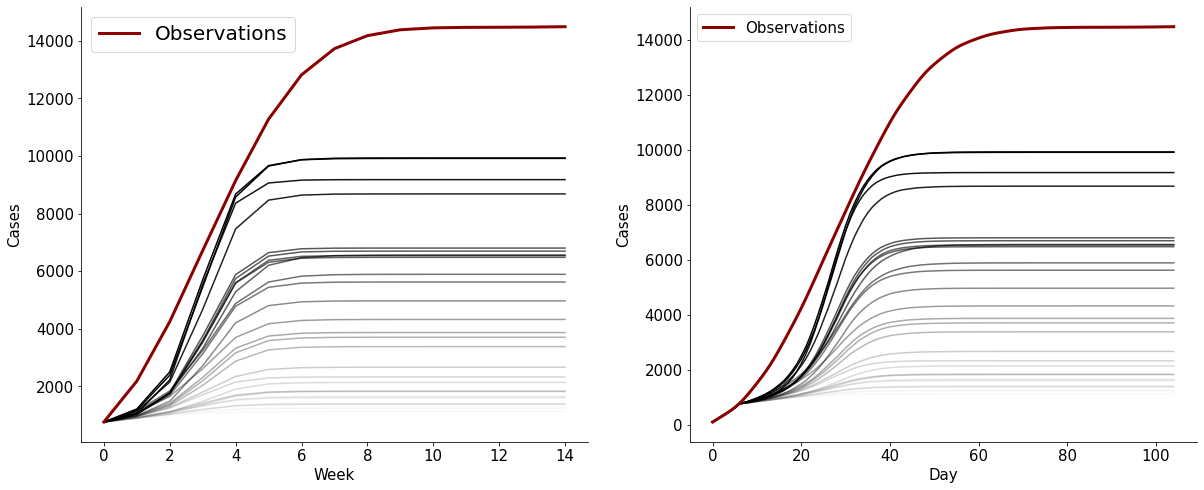

In [12]:
# Read in initial cases data (ued in seeding)
initial_cases = pd.read_csv("../../microsim/opencl/data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
initial_cases['CumulativeCases'] = initial_cases['num_cases'].cumsum()
initial_cases_weekly = pd.DataFrame({'OriginalCases':
                                    initial_cases['num_cases'].groupby(initial_cases['num_cases'].index // 7).sum()})
initial_cases_weekly['CumulativeCases'] = initial_cases_weekly.cumsum()

# Normalise fitness to 0-1 to calculate transparency
_fitness = np.array(fitness_l)  # Easier to do maths on np.array
fitness_norm = (_fitness - min(_fitness)) / (max(_fitness) - min(_fitness))

############## PLOT WEEKLY DATA
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax1.plot(x, sim_l[i],
            color="black", alpha=1 - fitness_norm[i]) # (1-x because high fitness is bad)
# Plot observations
ax1.plot(x, initial_cases_weekly['CumulativeCases'][0:int((105/7))], label="Observations", linewidth=3, color="darkred")
# Plot result from manually calibrated model
ax1.legend(fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel("Week", size=15)
ax1.set_ylabel("Cases",size=15)

############## PLOT DAILY DATA
x = range(len(OpenCLRunner.get_cumulative_new_infections(summaries_l[1])))
for i in range(len(summaries_l)):
    ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]),
            # label=f"Particle {df.index[sample_idx[i]]}",
            color="black", alpha=1 - fitness_norm[i]  # (1-x because high fitness is bad)
            )
    # ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"Fitness {round(fitness_l[i])}", fontsize=8)
    # ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"P{df.index[sample_idx[i]]}, F{round(fitness_l[i])}", fontsize=8)
# Plot observations
ax2.plot(x, initial_cases['CumulativeCases'][0:105], label="Observations", linewidth = 3, color="darkred")
# Plot result from manually calibrated model
# ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# Format
ax2.legend(fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel("Day", size=15)
ax2.set_ylabel("Cases",size=15)

del _fitness, fitness_norm


### Save/pickle

In [41]:
fname = "2windows_7seeds_OldDistance_abc.pkl"
with open( fname, "wb" ) as f:
        pickle.dump( history, f)